In [41]:
import re
import gensim 
import mglearn
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import konlpy
import ckonlpy
from konlpy.utils import pprint
from konlpy.tag import Hannanum
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
from konlpy.tag import Kkma, Mecab
import pyLDAvis.gensim
import pyLDAvis.sklearn
import collections
from gensim.models.word2vec import Word2Vec
import copy
import soynlp
from soynlp.utils import DoublespaceLineCorpus
from soynlp.noun import LRNounExtractor_v2
import networkx as nx
import matplotlib.pyplot as plt
from __future__ import print_function
from textrankr import TextRank

plt.rc('font', family='NanumBarunGothicOTF')

In [90]:
class MeEnewsAnalyzer():

        def __init__ (self):
            self.idx_result_df = pd.DataFrame()

            input_file_name = "./result/indexing.txt"

            self.idx_result_df = pd.read_csv(input_file_name,encoding="UTF8",header=None)
            self.filtered_idx_result_df = pd.DataFrame()
            self.idx_result_df.columns = ['date','title','content_url_list','file_list']

            self.climate_words = ['기후변화','가뭄', '강추위', '결빙', '그린란드빙하', '기후', '남극빙하', '녹색성장', '대설', '라니냐',
                                  '무더위', '북극빙하', '사막화', '산성비', '쓰나미', '엘니뇨', '열대야', '열섬', '열파', '온난',
                                  '온실가스', '우박', '이산화탄소', '이상고온', '이상기온', '이상저온', '장마', '적설', '집중강우',
                                  '집중호우', '침수', '탄소', '태풍', '파랑', '패랑', '폭설', '폭염', '폭우', '풍량', '풍수해', '한파',
                                  '해수면', '해일', '혹서', '혹한', '홍수', '황사비', '히말라야빙하']

            self.climate_words = "|".join(self.climate_words)
            self.kkma = Kkma()
            self.twitter = ckonlpy.tag.Twitter()
            self.twitter2 = konlpy.tag.Twitter()
            
            self.document_topics = None
            self.topic_words = None
            self.filtered_sentences = None
            self.morph_analyzer = None
            self.w2v_model = None
            self.keyword_list = None
            self.topic_list = None
            self.corpus = None
            self.nouns  = None
            self.temp = None
            
            # 결과저장 디렉토리 생성
            dirname = 'result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
                
            dirname = './analysis_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
                
            dirname = './lda_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')

            dirname = './doc_trend_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
                
            dirname = './keyword_frequency_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
            
            dirname = './keyword_frequency_yearly_basis_result/'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')  
                
                
            dirname = './keyword_trend_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
                
            dirname = './lda_stat'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')    
                
            dirname = './lda_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
                
            dirname = './sentence_level_cowords'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
            
            dirname = './doc_level_cowords'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
                
            dirname = './w2v_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')
                
            dirname = './filtered_sentence_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')    
                
            dirname = './press_statistic_result/'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/') 
            
            dirname = './sentence_summary_result'
            if ((os.path.isdir('./' + dirname + '/')) == False):
                os.mkdir('./' + dirname + '/')  
                
            # 네이버 추가 전처리    
            self.idx_result_df['date'] = list(map(str, self.idx_result_df['date']))
            self.idx_result_df['file_list'] = list(map(lambda x: os.path.dirname(input_file_name) + "/" + os.path.basename(x), self.idx_result_df['file_list'].tolist()))

            self.filtered_idx_result_df =  self.idx_result_df
            
            # remove duplicate
            self.remove_duplicate()
            
        def remove_duplicate(self):
            self.filtered_idx_result_df = self.filtered_idx_result_df.drop_duplicates(subset=['title','date'],keep="last")
            self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
        
        # 날짜 필터링
        def filtering_date(self,start_date = None, end_date = None):
            dt_index = pd.date_range(start=start_date, end = end_date)
            dt_list = dt_index.strftime("%Y-%m-%d").tolist()
            idx = list(map(lambda x: x in dt_list, self.filtered_idx_result_df['date'].tolist()))
            self.filtered_idx_result_df = self.filtered_idx_result_df.iloc[idx]
            self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            #print(self.idx_result_df[self.idx_result_df['date'] in dt_list]) 
                        
        # 문서 필터링
        # is_del = True : 제거 필터링 / is_del = False : 포함 필터링
        def filtering_contents(self,rexp,is_del=False):
            file_list =  self.filtered_idx_result_df['file_list'].tolist()
            #print(file_list)
            fidx = []
            didx = []
            for i in range(len(file_list)):
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                f.close()
                p = re.compile(rexp)
                ridx = p.search(doc)
                    
                if(ridx == None):
                   #print("없음")
                    didx.append(i)
                
                else:
                    fidx.append(i)
                
            #print(fidx)
            if is_del == False:
                #rint(fidx)
                self.filtered_idx_result_df = self.filtered_idx_result_df.iloc[fidx]
                self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            else :
                self.filtered_idx_result_df = self.filtered_idx_result_df.iloc[didx]
                self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            #print(self.idx_result_df)
        

        # 필터링 된 결과 저장 
        def save_filtered_result(self):
            self.idx_result_df.to_csv("./result/findexing.txt",header=None,index=None,encoding="UTF8")
            
        # 두개의 인덱스 파일 결합   
        def combine_idx_result(self, prev):
            #print("Current")
            #print(self.filtered_idx_result_df)
            #print("Prev Index result")
            #print(prev.filtered_idx_result_df)
            self.filtered_idx_result_df = pd.concat([self.filtered_idx_result_df,prev.filtered_idx_result_df])
            self.filtered_idx_result_df = self.filtered_idx_result_df.drop_duplicates(['date','title'])
            self.filtered_idx_result_df = self.filtered_idx_result_df.sort_values(["file_list"], ascending=True)
            self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            
        # 문서 트랜드 분석
        def doc_trend_analysis(self, norm=False, prefix="",title="환경부 보도자료",xlab="년도",ylab="문서수"):
            
            # 날짜 추출
            dt_list = self.filtered_idx_result_df['date'].tolist()
            dt_cnt = collections.Counter(list(map(lambda x : x.split("-")[0], dt_list)))
         
            x = list(dt_cnt.keys())
            y = list(dt_cnt.values())
            
            # norm= True (정규화, 상대적 비교)
            if(norm == True) :
                prefix = prefix + "norm_"
                dt_index = pd.date_range(start=min(dt_list), end = max(dt_list))
                all_dt_list = dt_index.strftime("%Y-%m-%d").tolist()
                idx = list(map(lambda x: x in all_dt_list, self.idx_result_df['date'].tolist()))
                temp_df = self.idx_result_df.iloc[idx]
                temp_df = temp_df.reset_index(drop=True)
                temp_df_list = temp_df['date'].tolist()
                #print(temp_df)

                all_dt_cnt = collections.Counter(list(map(lambda x : x.split("-")[0], temp_df_list)))
                all_y = list(all_dt_cnt.values())

                y =  np.array(y) / np.array(all_y)
                y =  y.tolist()

            plt.xticks(rotation=50)
            plt.plot(x,y,c="b", lw=2, ls="--", marker="o", ms=10, mec="g", mew=2, mfc="r")
            plt.title(title)
            plt.xlabel(xlab)
            plt.ylabel(ylab)
            plt.savefig("./doc_trend_result/" + prefix + "doc_trends.png",dpi=200)

            result = pd.DataFrame([x,y]).transpose()
            result.to_csv("./doc_trend_result/" + prefix + "doc_trends.csv",encoding="UTF8")
            
        # 키워드 빈도수 체크
        def keyword_frequency_analysis(self,num=100,is_tfidf = True,is_noun=True, ma="twitter2",prefix="",s_words=[]):
            
            if ma == "twitter":
                self.morph_analyzer = self.twitter
            if ma == "twitter2":
                self.morph_analyzer = self.twitter2    
                
            file_list = self.filtered_idx_result_df['file_list'].tolist()
            print(len(file_list))
            print("Keyword Analysis")
            corpus = [""] * len(file_list)
      
            # 파일 내용 읽어서 코퍼스에 저장

            for i in range(len(file_list)):
                #-print(i)
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                f.close()
                corpus[i] = " ".join(self.morph_analyzer.nouns(doc))


            # Stop words 
            stop_words = ["전략", "연구", "평가", "마련", "조사", "관리", "보다", "분석", "구축","개발","정책","대책",
                          "관련","전문가","예정","이번","환경부", "환경", "기술", "사업", "산업", "기업","우리나라", "또한",
                          "총회", "대한", "통해", "한국","국내","개최","행사","우수","서울","장관","호남권","피해","해외","일자리",
                          "박람회","지원", "위해", "총회","국제","분야","환경기술","10","20", "지정","전국","선정","사용","다양","하게",
                          "대상","대상으로","제품", "공단","이상","정보","대해","국민","지난","올해","현재","1부","관한","이용","증가",
                          "협력","도입","향후","발표","이라","참여","포함","수도권","된다", "있으며","1부","등이","이후","15","12",
                          "정부", "회의","기여","활성화","수준" "진행","처리","내용","나타났다", "대비","하였다","2010년","2011년",
                          "2012년","2013년","2014년","2015년","2016년","2017년","실천","말했다","현장","구성","최초","확산","홈페이지",
                          "가능","사진","나타","설명","6월","제공","효과","우리","kr","10월","계기", "거나","평균","이하","예방","기관",
                          "수행","5월","사례","업체","사장","대해서","최근","원장","추가","9월","노력","기존","했다","직접","새로",
                          "참여하","소개","7월","4월","시작","윤성규","이에","4월","통한","성과","관심","가장", "적용","하고","과정",
                          "보급","동안","연간","거쳐","사업장","주요","시행","프로그램","시설","국민","국립환경과학원","국립생물자원관",
                          "국립공원관리공단","한펀","논의","공모전","자료","발견","서식","현황","국가","기대","대하", "활동","확보","세계",
                          "국립생태원","홍보","수준","진행","체결","개정","수립","주민","필요","한편","13","5개","11","지역",
                          "11월","고려","질의응답","서비스","같은","적극","하도","이나","한다","17","16","운영","확대","강화","활용","확인",
                          "계획","설치","발생","개선","기준","제도","공동"]
            
            stop_words = list(set(stop_words))
         
            if(len(s_words) != 0):
                stop_words = s_words
                
            vect = CountVectorizer(stop_words = stop_words,ngram_range=(1, 2),min_df=0.005,max_df=0.3)
            #ocab = vectorizer.get_feature_names()
            #print("Execution")
            X = vect.fit_transform(corpus)
            if(is_tfidf == True):
                X = TfidfTransformer().fit_transform(X)
                prefix = prefix + "norm_"
                
            count = X.toarray().sum(axis=0)
            idx = np.argsort(-count)
            count = count[idx]

            feature_name = np.array(vect.get_feature_names())[idx]
            #plt.bar(range(len(count)), count)
            #plt.show()

            self.keyword_list = list(zip(feature_name[:num], count[:num]))
            result = pd.DataFrame(self.keyword_list)
            result.to_csv("./keyword_frequency_result/" + prefix + "keyword_frequency.csv",encoding="UTF8")            
            
        # 키워드 트랜드 분석
        # norm = 년도별 정규화
        # voca = "분석할 단어 설정"
        
        
        def keyword_frequency_yearly_basis_analysis(self,num=100,is_tfidf = True,is_noun=True, ma="twitter2",prefix="",s_words=[],start_year='2010',end_year='2017'):            
            if ma == "twitter":
                self.morph_analyzer = self.twitter
            if ma == "twitter2":
                self.morph_analyzer = self.twitter2    
                
            file_list = self.filtered_idx_result_df['file_list'].tolist()
            print(len(file_list))
            print("Keyword Analysis")
            corpus = [""] * len(file_list)
            
            result_mat = pd.DataFrame()
            
            # 파일 내용 읽어서 코퍼스에 저장
            for year in range(int(start_year),int(end_year)+1):
                start_date = str(year) + "-01-01"
                end_date = str(year) + "-12-31"
                dt_index = pd.date_range(start=start_date, end = end_date)
                dt_list = dt_index.strftime("%Y-%m-%d").tolist()
                print(dt_list)
                idx = list(map(lambda x: x in dt_list, self.filtered_idx_result_df['date'].tolist()))
            
                filtered_idx_result_df = self.filtered_idx_result_df.iloc[idx]
                file_list = filtered_idx_result_df['file_list'].tolist()
                print(file_list)
                
                for i in range(len(file_list)):
                    #-print(i)
                    f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                    doc = f.read()
                    f.close()
                    corpus[i] = " ".join(self.morph_analyzer.nouns(doc))


                # Stop words 
                stop_words = ["전략", "연구", "평가", "마련", "조사", "관리", "보다", "분석", "구축","개발","정책","대책",
                              "관련","전문가","예정","이번","환경부", "환경", "기술", "사업", "산업", "기업","우리나라", "또한",
                              "총회", "대한", "통해", "한국","국내","개최","행사","우수","서울","장관","호남권","피해","해외","일자리",
                              "박람회","지원", "위해", "총회","국제","분야","환경기술","10","20", "지정","전국","선정","사용","다양","하게",
                              "대상","대상으로","제품", "공단","이상","정보","대해","국민","지난","올해","현재","1부","관한","이용","증가",
                              "협력","도입","향후","발표","이라","참여","포함","수도권","된다", "있으며","1부","등이","이후","15","12",
                              "정부", "회의","기여","활성화","수준" "진행","처리","내용","나타났다", "대비","하였다","2010년","2011년",
                              "2012년","2013년","2014년","2015년","2016년","2017년","실천","말했다","현장","구성","최초","확산","홈페이지",
                              "가능","사진","나타","설명","6월","제공","효과","우리","kr","10월","계기", "거나","평균","이하","예방","기관",
                              "수행","5월","사례","업체","사장","대해서","최근","원장","추가","9월","노력","기존","했다","직접","새로",
                              "참여하","소개","7월","4월","시작","윤성규","이에","4월","통한","성과","관심","가장", "적용","하고","과정",
                              "보급","동안","연간","거쳐","사업장","주요","시행","프로그램","시설","국민","국립환경과학원","국립생물자원관",
                              "국립공원관리공단","한펀","논의","공모전","자료","발견","서식","현황","국가","기대","대하", "활동","확보","세계",
                              "국립생태원","홍보","수준","진행","체결","개정","수립","주민","필요","한편","13","5개","11","지역",
                              "11월","고려","질의응답","서비스","같은","적극","하도","이나","한다","17","16","운영","확대","강화","활용","확인",
                              "계획","설치","발생","개선","기준","제도","공동"]

                stop_words = list(set(stop_words))

                if(len(s_words) != 0):
                    stop_words = s_words

                vect = CountVectorizer(stop_words = stop_words,ngram_range=(1, 2),min_df=0.005,max_df=0.3)
                #ocab = vectorizer.get_feature_names()
                #print("Execution")
                X = vect.fit_transform(corpus)
                if(is_tfidf == True):
                    X = TfidfTransformer().fit_transform(X)
     

                count = X.toarray().sum(axis=0)
                idx = np.argsort(-count)
                count = count[idx]

                feature_name = np.array(vect.get_feature_names())[idx]
                #plt.bar(range(len(count)), count)
                #plt.show()

                result = list(zip(feature_name[:num], count[:num]))
                result = pd.DataFrame(result)
                result_mat = pd.concat([result_mat,result],axis=1)
            
            if(is_tfidf == True):
                prefix = prefix + "norm_"
            result_mat.to_csv("./keyword_frequency_yearly_basis_result/" + prefix + "keyword_frequency_yearly_basis.csv",encoding="UTF8")            
            
        # 키워드 트랜드 분석
        # norm = 년도별 정규화
        # voca = "분석할 단어 설정"
        
        
        def keyword_trend_analysis(self, prefix="", norm=False, ma ='twitter2',voca = ""):
            
            if ma == "twitter":
                self.morph_analyzer = self.twitter
            if ma == "twitter2":
                self.morph_analyzer = self.twitter2
            
            temp_df = self.filtered_idx_result_df
            file_list = self.filtered_idx_result_df['file_list'].tolist()
            
            x = list()
            
            # 각 vocabulary에 대해서 수행
            result = pd.DataFrame()
            for v in voca:
                #print(v)
                fidx = []
                didx = []
                for i in range(len(file_list)):
                    f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                    doc = f.read()
                    f.close()
                    p = re.compile(v)
                    ridx = p.search(doc)
                    if(ridx == None):
                        didx.append(i)
                    else:
                        fidx.append(i)
                    
                # 날짜 추출
                dt_list = [self.filtered_idx_result_df['date'].tolist()[sidx] for sidx in fidx]
                dt_cnt = collections.Counter(list(map(lambda x : x.split("-")[0], dt_list)))
            
                x = list(dt_cnt.keys())
                y = list(dt_cnt.values())
                y = pd.DataFrame(y)
                result = pd.concat([result,y],axis=1)
                
           # dt_list = self.filtered_idx_result_df['date'].tolist()   
           # dt_cnt = collections.Counter(list(map(lambda x : x.split("-")[0], dt_list)))        
            
            result.columns = voca

            if(norm == True):
                prefix = "norm_" + prefix
                temp_df_list = self.filtered_idx_result_df['date'].tolist()
                all_dt_cnt = collections.Counter(list(map(lambda x : x.split("-")[0], temp_df_list)))
                
                all_y = list(all_dt_cnt.values())
                for i in range(len(all_y)):
                    #print(result)
                    result.iloc[i,:] = result.iloc[i,:] / all_y[i]
            
            x = pd.DataFrame(x)
            result = pd.concat([x,result],axis=1)
                        
            result.to_csv("./keyword_trend_result/" + prefix + "keyword_trends.csv",encoding="UTF8")
    
        # 토픽 모델링
        def topic_modeling(self,n_topics, ma = "twitter2", prefix = "",random_seed=1,s_words=[]):
            
            if ma == "twitter":
                self.morph_analyzer = self.twitter
            if ma == "twitter2":
                self.morph_analyzer = self.twitter2
                       
            # 형태소 분석을 기본적으로 수행
            file_list = self.filtered_idx_result_df['file_list'].tolist()
            #print(file_list)
            corpus = [""] * len(file_list)

            # 파일 내용 읽어서 코퍼스에 저장

            for i in range(len(file_list)):
                #print(i)
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                f.close()
                corpus[i] = " ".join(self.morph_analyzer.nouns(doc))

            #print(corpus)

            # Stop words 
            stop_words = ["공모전","전략", "연구", "평가", "마련", "조사", "관리", "보다", "분석", "구축","개발","정책","대책",
                          "관련","전문가","예정","이번","환경부", "환경", "기술", "사업", "산업", "기업","우리나라", "또한",
                          "총회", "대한", "통해", "한국","국내","개최","행사","우수","서울","장관","호남권","피해","해외","일자리","박람회",
                          "지원", "위해", "총회","국제","분야","환경기술","관련자료 보도자료","국민","참여","이기","선정","부문","홍보","강화",
                          "초과", "나타", "운영","확대","정부","진행","제공","사용","가능","개선","기관","다양","취급","위반","법령"]
  
            stop_words = list(set(stop_words))
    
            if(len(s_words) != 0):
                stop_words = s_words
            vect = CountVectorizer(stop_words = stop_words,ngram_range=(1, 2),min_df=0.05,max_df=0.3)
            X = vect.fit_transform(corpus)
            X = TfidfTransformer().fit_transform(X)

            #vect = CountVectorizer(stop_words = stop_words,min_df=0.005,max_df=0.3)

            n_words = 300
            for i in n_topics:
                print(i)
                # LDA 수횅
                lda = LatentDirichletAllocation(n_components = i,learning_method="batch",random_state=random_seed)
                #lda = LatentDirichletAllocation(learning_method="batch")
                self.document_topics = lda.fit_transform(X)
                
                sorting = np.argsort(lda.components_, axis=1)[:,::-1]
                feature_names = np.array(vect.get_feature_names())
                
                #mglearn.tools.print_topics(topics=range(i), feature_names = feature_names, sorting=sorting, topics_per_chunk=20, n_words=20)
                #self.filtered_idx_result_df["topic"] = np.argmax(self.document_topics,axis=1).tolist()
                
                self.topic_list = np.argmax(self.document_topics,axis=1).tolist()
                
                self.topic_words = pd.DataFrame(feature_names[sorting])
                self.topic_words = self.topic_words.T
                self.topic_words = self.topic_words[:n_words]
                
                # 파일이름 지정
                filename =  "./lda_result/" +  str(prefix) + "_result_n_" + str(i) + "_" 

                # 파일 저장
                self.document_topics = pd.DataFrame(self.document_topics)
                self.document_topics.to_csv(filename + "document_topic.csv",header=None,index=False,encoding="UTF8")
                self.topic_words.to_csv(filename + "topic_words.csv",header=None,index=False,encoding="UTF8")
                
                # 시각화 및 저장
                self.topic_modeling_vis(lda, X, vect, filename)

        def topic_modeling_vis(self,lda,dtm,vect,filename):
            pyldavis = pyLDAvis.sklearn.prepare(lda, dtm,vect)
            pyLDAvis.save_html(pyldavis,filename + "lda.html")
            
        def select_topics(self,topics):
            #print("Select Topics")
            topic_list = self.topic_list
            #print(topic_list)
            tidx = list(map(lambda x: x in topics , topic_list))
            #print(tidx)
            
            self.filtered_idx_result_df = self.filtered_idx_result_df.iloc[tidx,:]
            self.filtered_idx_result_df = self.filtered_idx_result_df.reset_index(drop=True)
            self.topic_list = np.array(self.topic_list)[tidx].tolist()
            
        def topic_modeling_statistics(self,prefix=""):
            
            topic_list = self.topic_list
            result = pd.DataFrame()

            dt = None
            for t in range(max(topic_list) + 1):
                print(t)
                sub_idx = (np.array(topic_list) == t)
                sub_idx = list(sub_idx)
                sub_result = self.filtered_idx_result_df.loc[sub_idx,:]
                date_list = sub_result['date']
                all_dt_cnt = collections.Counter(list(map(lambda x : x.split("-")[0], date_list)))
                all_y = list(all_dt_cnt.values())
                all_y = pd.DataFrame(all_y)
                result = pd.concat([result,all_y],axis=1)            

            dt = list(all_dt_cnt.keys())
            dt = pd.DataFrame(dt)
            result = pd.concat([dt,result],axis=1)

            result.to_csv("./lda_stat/" + prefix + "lda_stat.csv",encoding="UTF8")
        
            
        def extract_sentence(self,w1,ma="twitter2",prefix=""):
            if ma == "twitter":
                self.morph_analyzer = self.twitter
            if ma == "twitter2":
                self.morph_analyzer = self.twitter2  

            file_list =  self.filtered_idx_result_df['file_list'].tolist()
            filtered_sentences= []
            
            for i in range(len(file_list)):
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                sentences = self.split_text(doc)
                
                for s in sentences:
                    filtered_sentences.append(s)
            
            self.temp = pd.DataFrame(filtered_sentences)
            
            for w in w1:
                temp = []
                for s in filtered_sentences :
                    p = re.compile(w)
                    ridx = p.search(s)

                    if(ridx == None):
                        continue   
                    s = s.strip()
                    temp.append(s)
                filtered_sentences = temp
            
            self.filtered_sentences = filtered_sentences
            result = pd.DataFrame(self.filtered_sentences)
            
            result.to_csv("./filtered_sentences_result/" + prefix + "filtered_sentences.csv")
            
        # word2vec 학습
        def training_keyword_w2v(self,ma="twitter2"):
            file_list = self.filtered_idx_result_df['file_list'].tolist()
            corpus = [""] * len(file_list)
            # 형태소 분석기 선택

            if ma == "twitter":
                self.morph_analyzer = self.twitter
            if ma == "twitter2":
                self.morph_analyzer = self.twitter2
                
            # 파일 내용 읽어서 코퍼스에 저장
            for i in range(len(file_list)):
                #print(i)
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                f.close()
                doc = re.sub('[^가-힝0-9a-zA-Z\\s]', '', doc)
                corpus[i] = self.morph_analyzer.nouns(doc)

            model = Word2Vec(corpus)
            model.init_sims(replace=True)
            self.w2v_model = model
            
        # word2vec 학습 결과 저장
        def w2v_analysis(self,word,num=100):
            #print(self.w2v_model.most_similatr(word,topn=num))
            result = pd.DataFrame(self.w2v_model.most_similar(word,topn=num))
            result2 = pd.DataFrame(self.w2v_model.predict_output_word(word, topn=num))
            filename = "".join(word)
            result.to_csv("./w2v_result/" + "w2v_" + filename + ".csv",encoding="UTF8")
            result2.to_csv("./w2v_result/" + "w2v2_" + filename + ".csv",encoding="UTF8")
            
        def to_gephi(self,w2vwords=500,alpha=1.2,beta=1.2,ma = 'twitter'):
            
            if ma == "twitter":
                self.morph_analyzer = self.twitter
               
            corpus = []
        
            for i in range(len(file_list)):
                #-print(i)
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                f.close()
                corpus.append(" ".join(morph_anal.nouns(doc)))

            stop_words = []

            # get word2vec 

            w2vwords = ['기후변화','대응']
            result = self.w2v_model.most_similar(positive=w2vwords,topn=500)
            result = pd.DataFrame(result)
            file_list = ma.filtered_idx_result_df.file_list
            w_list = result[0].tolist()

            for i in range(len(w_list)) :
                w_list[i] = re.sub(r'[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '',w_list[i])   

            # w2v 단어로 필터링

            file_list =  ma.filtered_idx_result_df['file_list'].tolist()

            for w in w2vwords:
                fidx = []
                for i in range(len(file_list)):
                    f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                    doc = f.read()
                    p = re.compile(w1)
                    ridx = p.search(doc)
                    if(ridx != None):
                        fidx.append(i)
                file_list = [file_list[t] for t in fidx]


            widx = []
            for idx in range(len(w_list)):
                #print(w)
                fidx = []
                for i in range(len(file_list)):
                    f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                    doc = f.read()
                    p = re.compile(w_list[idx])
                    ridx = p.search(doc)
                    if(ridx != None):
                        fidx.append(i)
                        break         
                if(len(fidx) != 0):
                    widx.append(idx)

            alpha = 1.2

            result.iloc[widx,1] = result.iloc[widx,1] * alpha

        def keyword_association_analysis(self,text):
            new_text = text.replace(".",".\n").replace("?","?\n").replace("!","!\n")
            sentences = new_text.splitlines()
            return sentences

        def split_text(self,text):
            new_text = text.replace(".",".\n").replace("?","?\n").replace("!","!\n")
            sentences = new_text.splitlines()
            return sentences
        
        # 문서 레벨 동시 출현 단어
         # 문서 레벨 동시 출현 단어
        def doc_level_coccurrence_words(self,w1, num=100,ma="twitter2",prefix="",s_words=[]):
            if ma == "twitter":
                self.morph_analyzer = self.twitter
            if ma == "twitter2":
                self.morph_analyzer = self.twitter2  
                
            # 문서추출
            file_list =  self.filtered_idx_result_df['file_list'].tolist()
            temp_idx_result_df = pd.DataFrame()
            #print(file_list)
            
            fidx = []
            didx = []
           
            for i in range(len(file_list)):
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read() 
                for w in w1 :
                    p = re.compile(w)
                    ridx = p.search(doc)

                    if(ridx == None):
                        break
                    
                    if(w == w1[-1]):
                        fidx.append(i)
                    
                              
            fidx = list(set(fidx))
            #print(fidx)
            temp_idx_result_df = self.filtered_idx_result_df.iloc[fidx]
            temp_idx_result_df = temp_idx_result_df.reset_index(drop=True)
            
            file_list =  temp_idx_result_df['file_list'].tolist()
            
            corpus = []     
            for i in range(len(file_list)):
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                
                # 파일 내용 읽어서 코퍼스에 저장
                corpus.append(" ".join(self.morph_analyzer.nouns(doc)))

            # Stop words 
            stop_words = ["전략", "연구", "평가", "마련", "조사", "관리", "보다", "분석", "구축","개발","정책","대책",
                          "관련","전문가","예정","이번","환경부", "환경", "기술", "사업", "산업", "기업","우리나라", "또한",
                          "총회", "대한", "통해", "한국","국내","개최","행사","우수","서울","장관","호남권","피해","해외","일자리",
                          "박람회","지원", "위해", "총회","국제","분야","환경기술","10","20", "지정","전국","선정","사용","다양","하게",
                          "대상","대상으로","제품", "공단","이상","정보","대해","국민","지난","올해","현재","1부","관한","이용","증가",
                          "협력","도입","향후","발표","이라","참여","포함","수도권","된다", "있으며","1부","등이","이후","15","12",
                          "정부", "회의","기여","활성화","수준" "진행","처리","내용","나타났다", "대비","하였다","2010년","2011년",
                          "2012년","2013년","2014년","2015년","2016년","2017년","실천","말했다","현장","구성","최초","확산","홈페이지",
                          "가능","사진","나타","설명","6월","제공","효과","우리","kr","10월","계기", "거나","평균","이하","예방","기관",
                          "수행","5월","사례","업체","사장","대해서","최근","원장","추가","9월","노력","기존","했다","직접","새로",
                          "참여하","소개","7월","4월","시작","윤성규","이에","4월","통한","성과","관심","가장", "적용","하고","과정",
                          "보급","동안","연간","거쳐","사업장","주요","시행","프로그램","시설","국민","국립환경과학원","국립생물자원관",
                          "국립공원관리공단","한펀","논의","공모전","자료","발견","서식","현황","국가","기대","대하", "활동","확보","세계",
                          "국립생태원","홍보","수준","진행","체결","개정","수립","주민","필요","한편","13","5개","11","지역",
                          "11월","고려","질의응답","서비스","같은","적극","하도","이나","한다","17","16","운영","확대","강화","활용","확인",
                          "계획","설치","발생","개선","기준","제도","공동"]
            
            stop_words = list(set(stop_words))

            if(len(s_words) != 0):
                stop_words = s_words
                
            vect = CountVectorizer(stop_words = stop_words,ngram_range=(1, 2),min_df=0.005,max_df=0.3)
       
            X = vect.fit_transform(corpus)

            count = X.toarray().sum(axis=0)
            idx = np.argsort(-count)
            count = count[idx]

            feature_name = np.array(vect.get_feature_names())[idx]
            #plt.bar(range(len(count)), count)
            #plt.show()

            co_word_list = list(zip(feature_name[:num], count[:num]))
            co_word_list = pd.DataFrame(co_word_list)
            filename = "".join(w1)
            co_word_list.to_csv("./doc_level_cowords/" + prefix + filename + "_dcowords" + ".csv",encoding="UTF8")
        
        # 문장레벨 동시 출현 단어
        def sentence_level_coccurrence_words(self,w1, num=100, ma="twitter2",prefix="",s_words=[]):
            
            if ma == "twitter":
                self.morph_analyzer = self.twitter
            if ma == "twitter2":
                self.morph_analyzer = self.twitter2  

            file_list =  self.filtered_idx_result_df['file_list'].tolist()
            filtered_sentences= []
            for i in range(len(file_list)):
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                sentences = self.split_text(doc)
                
                for s in sentences:
                    filtered_sentences.append(s)
            
            self.temp = pd.DataFrame(filtered_sentences)
            
            for w in w1:
                temp = []
                for s in filtered_sentences :
                    p = re.compile(w)
                    ridx = p.search(s)

                    if(ridx == None):
                        continue   
                    s = s.strip()
                    temp.append(s)
                filtered_sentences = temp
            
            self.temp = pd.DataFrame(filtered_sentences)
            print(self.temp)
            # 파일 내용 읽어서 코퍼스에 저장
    
            corpus = []     
            for i in range(len(filtered_sentences)):
                corpus.append(" ".join(self.morph_analyzer.nouns(filtered_sentences[i])))
                
                
            # Stop words 
            stop_words = ["전략", "연구", "평가", "마련", "조사", "관리", "보다", "분석", "구축","개발","정책","대책",
                          "관련","전문가","예정","이번","환경부", "환경", "기술", "사업", "산업", "기업","우리나라", "또한",
                          "총회", "대한", "통해", "한국","국내","개최","행사","우수","서울","장관","호남권","피해","해외","일자리",
                          "박람회","지원", "위해", "총회","국제","분야","환경기술","10","20", "지정","전국","선정","사용","다양","하게",
                          "대상","대상으로","제품", "공단","이상","정보","대해","국민","지난","올해","현재","1부","관한","이용","증가",
                          "협력","도입","향후","발표","이라","참여","포함","수도권","된다", "있으며","1부","등이","이후","15","12",
                          "정부", "회의","기여","활성화","수준" "진행","처리","내용","나타났다", "대비","하였다","2010년","2011년",
                          "2012년","2013년","2014년","2015년","2016년","2017년","실천","말했다","현장","구성","최초","확산","홈페이지",
                          "가능","사진","나타","설명","6월","제공","효과","우리","kr","10월","계기", "거나","평균","이하","예방","기관",
                          "수행","5월","사례","업체","사장","대해서","최근","원장","추가","9월","노력","기존","했다","직접","새로",
                          "참여하","소개","7월","4월","시작","윤성규","이에","4월","통한","성과","관심","가장", "적용","하고","과정",
                          "보급","동안","연간","거쳐","사업장","주요","시행","프로그램","시설","국민","국립환경과학원","국립생물자원관",
                          "국립공원관리공단","한펀","논의","공모전","자료","발견","서식","현황","국가","기대","대하", "활동","확보","세계",
                          "국립생태원","홍보","수준","진행","체결","개정","수립","주민","필요","한편","13","5개","11","지역",
                          "11월","고려","질의응답","서비스","같은","적극","하도","이나","한다","17","16","운영","확대","강화","활용","확인",
                          "계획","설치","발생","개선","기준","제도","공동"]
            
            if(len(s_words) != 0):
                stop_words = s_words  
                
            vect = CountVectorizer(stop_words = stop_words,ngram_range=(1, 2),min_df=0.005,max_df=0.3)
       
            X = vect.fit_transform(corpus)

            count = X.toarray().sum(axis=0)
            idx = np.argsort(-count)
            count = count[idx]

            feature_name = np.array(vect.get_feature_names())[idx]
 
            co_word_list = list(zip(feature_name[:num], count[:num]))
            co_word_list = pd.DataFrame(co_word_list)
            
            filename = "".join(w1)
            co_word_list.to_csv("./sentence_level_cowords/" + prefix + filename + "_scowords" + ".csv",encoding="UTF8")
            
        # 명사 인식
        def add_unknown_nouns(self):
            file_list = self.filtered_idx_result_df['file_list'].tolist()
            corpus = [] 
            for i in range(len(file_list)):
                f = open(file_list[i], 'r',encoding='utf-8',errors="ignore")
                doc = f.read()
                doc = doc.replace("\n","")
                corpus.append("".join(doc))

            corpus = pd.DataFrame(corpus)
            corpus.to_csv("./corpus.txt",sep=" ", header=None)
            
            corpus_fname = './corpus.txt'
            sents = DoublespaceLineCorpus(corpus_fname, iter_sent=True)

            noun_extractor = LRNounExtractor_v2(verbose=False)
            noun_extractor.train(sents)
            nouns = noun_extractor.extract()
            nouns = list(nouns.keys())
            self.nouns = nouns
            self.twitter.add_dictionary(nouns, 'Noun')
                
           # nouns
        
        def sentence_summarization(self,cnt=10):
            
            t_list = []
            for s in self.filtered_sentences:
                t= re.sub('[^가-힝0-9a-zA-Z\\s]', '', s)
                t_list.append(t)
                
            p_sentences = ". ".join(t_list)
            textrank = TextRank(p_sentences)
            t = textrank.summarize(count=cnt)
            t = t.split("\n")
            
            t = pd.DataFrame(t)
            t.columns=['Sentences']
            result.to_csv("./sentence_summary_result/" + "ss_" + filename + ".csv",encoding="UTF8")
            
            
            

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


2099
Keyword Analysis
2099
Keyword Analysis


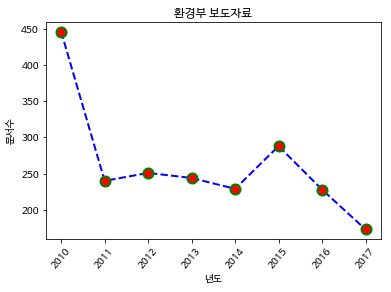

In [24]:
# 전체문서에 대한 기본적인 통계

s = MeEnewsAnalyzer()
s.filtering_date('2005-01-01','2017-12-31')

# 전체 문서 통계
s.doc_trend_analysis()

# 명사 인식기 실행 및 사전에 추가
#s.add_unknown_nouns()

# 전체 문서 주요 키워드 빈도수 추이
s.keyword_frequency_analysis(num=200,is_tfidf=True)
s.keyword_frequency_analysis(num=200,is_tfidf=False)

# 주요 키워드 추이 (액셀로 그림 그려야됨)
keyword_list = ['온실가스','기후변화','쓰레기', '화학물질','폐기물','재활용','에너지','미세먼지','친환경','소음','생물다양성','생물자원','생태계']
s.keyword_trend_analysis(voca=keyword_list,norm=True)
s.keyword_trend_analysis(voca=keyword_list,norm=False)

In [33]:
s.idx_result_df

,date,title,content_url_list,file_list
0,2010-05-24,하늘을 사랑하는 어린 다빈치들의 향연,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100524_5.txt
1,2010-05-24,"한국환경공단, 상수관망 최적관리시스템 사업",http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100524_1.txt
2,2010-05-24,한·중·일 3국 환경장관회의 결과,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100524_4.txt
3,2010-05-24,잔반ZERO에 도전한다,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100524_3.txt
4,2010-05-24,공공환경시설 온실가스 측정 시범사업 실시,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100524_2.txt
5,2010-05-25,어린이 환경백서 발간,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100525_3.txt
6,2010-05-25,인터넷으로 환경분쟁조정 신청 가능해져,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100525_1.txt
7,2010-05-25,석면 안전관리를 위한 자발적 협약 체결,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100525_4.txt
8,2010-05-25,"환경의날기념, 한국미술70인전-아름다운 산하전",http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100525_2.txt
9,2010-05-26,"깨끗한 수돗물, 농어촌과 섬마을에 까지",http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100526_2.txt


In [91]:
# 키워드 기반 기후변화 문서 정제

ma1 = MeEnewsAnalyzer()
ma1.filtering_date('2005-01-01','2017-12-31')
#ma1.filtering_contents("인사발령|공개모집|필기시험|발령|인사 발령|과장|전보 일자|공무원|대변인|국장|승진|공모전|캠프 캐롤|고엽제 매립",True)
#ma1.add_unknown_nouns()

# True 일경우 포함단어의 문장은 제외
ma1.filtering_contents(ma1.climate_words,False)
ma1.filtered_idx_result_df

/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


,date,title,content_url_list,file_list
0,2010-05-24,하늘을 사랑하는 어린 다빈치들의 향연,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100524_5.txt
1,2010-05-24,"한국환경공단, 상수관망 최적관리시스템 사업",http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100524_1.txt
2,2010-05-24,한·중·일 3국 환경장관회의 결과,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100524_4.txt
3,2010-05-24,공공환경시설 온실가스 측정 시범사업 실시,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100524_2.txt
4,2010-05-25,어린이 환경백서 발간,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100525_3.txt
5,2010-05-25,"환경의날기념, 한국미술70인전-아름다운 산하전",http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100525_2.txt
6,2010-05-26,"깨끗한 수돗물, 농어촌과 섬마을에 까지",http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100526_2.txt
7,2010-05-27,탄소 포인트제 참여자 100만 돌파!!,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100527_2.txt
8,2010-05-27,사회간접자본 사업에 재생자재 사용의무화 시행,http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100527_1.txt
9,2010-05-28,"신갈나무와 공생 버섯, 우리는 녹색 일꾼",http://www.me.go.kr/home/web/board/read.do;jse...,./result/20100528_1.txt


664
Keyword Analysis
664
Keyword Analysis


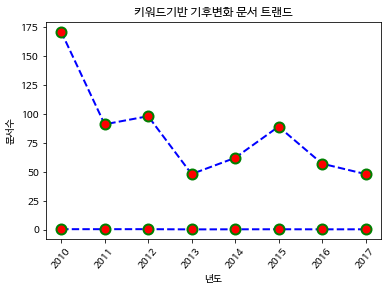

In [27]:
# 키워드기반 기후변화 문서들에 대한 통계 

# 문서 추세분석

ma1.doc_trend_analysis(norm=False, prefix = "kc_",title = "키워드기반 기후변화 문서 트랜드", ylab="문서수")
ma1.doc_trend_analysis(norm=True, prefix = "kc_",title = "키워드기반 기후변화 문서 트랜드", ylab="문서수")

# 키워드 분석

ma1.keyword_frequency_analysis(is_tfidf=False,prefix="kc_")
ma1.keyword_frequency_analysis(is_tfidf=True,prefix="kc_")

In [44]:
# LDA기반 기후변화 문서 찾기
ma2 = MeEnewsAnalyzer()
ma2.filtering_date('2005-01-01','2017-12-31')
# 토픽모델링을 통한 기후변화 클러스터 추출
ma2.topic_modeling([5],prefix = "s1",random_seed=1)


/usr/local/lib/python3.6/dist-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


5


/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [28]:
ma2.topic_words

,0,1,2,3,4
0,생물,녹색,생물,국립공원,기준
1,마리,온실가스,생물다양성,탐방,물질
2,발견,친환경,세계,공단,시설
3,식물,실천,회의,국립공원 공단,화학물질
4,복원,쓰레기,자원,북한,배출
5,서식,탄소,생물 자원,자연,수질
6,야생,기후변화,협력,공원,처리
7,생태계,감축,보전,지리산,오염
8,생태,제품,위원회,생태,유해
9,멸종위기,에너지,논의,체험,안전


In [45]:
ma2.select_topics([1])

In [92]:
# 두개의 코퍼스 합치기


ma = ma1
ma.combine_idx_result(ma2)

In [93]:
ma.keyword_frequency_yearly_basis_analysis()
ma.keyword_frequency_yearly_basis_analysis(is_tfidf=False)
#ma.filtered_idx_result_df['date']

967
Keyword Analysis
['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08', '2010-01-09', '2010-01-10', '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15', '2010-01-16', '2010-01-17', '2010-01-18', '2010-01-19', '2010-01-20', '2010-01-21', '2010-01-22', '2010-01-23', '2010-01-24', '2010-01-25', '2010-01-26', '2010-01-27', '2010-01-28', '2010-01-29', '2010-01-30', '2010-01-31', '2010-02-01', '2010-02-02', '2010-02-03', '2010-02-04', '2010-02-05', '2010-02-06', '2010-02-07', '2010-02-08', '2010-02-09', '2010-02-10', '2010-02-11', '2010-02-12', '2010-02-13', '2010-02-14', '2010-02-15', '2010-02-16', '2010-02-17', '2010-02-18', '2010-02-19', '2010-02-20', '2010-02-21', '2010-02-22', '2010-02-23', '2010-02-24', '2010-02-25', '2010-02-26', '2010-02-27', '2010-02-28', '2010-03-01', '2010-03-02', '2010-03-03', '2010-03-04', '2010-03-05', '2010-03-06', '2010-03-07', '2010-03-08', '2010-03-09', '2010-03-10', '2010-03-11'

['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08', '2011-01-09', '2011-01-10', '2011-01-11', '2011-01-12', '2011-01-13', '2011-01-14', '2011-01-15', '2011-01-16', '2011-01-17', '2011-01-18', '2011-01-19', '2011-01-20', '2011-01-21', '2011-01-22', '2011-01-23', '2011-01-24', '2011-01-25', '2011-01-26', '2011-01-27', '2011-01-28', '2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05', '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-09', '2011-02-10', '2011-02-11', '2011-02-12', '2011-02-13', '2011-02-14', '2011-02-15', '2011-02-16', '2011-02-17', '2011-02-18', '2011-02-19', '2011-02-20', '2011-02-21', '2011-02-22', '2011-02-23', '2011-02-24', '2011-02-25', '2011-02-26', '2011-02-27', '2011-02-28', '2011-03-01', '2011-03-02', '2011-03-03', '2011-03-04', '2011-03-05', '2011-03-06', '2011-03-07', '2011-03-08', '2011-03-09', '2011-03-10', '2011-03-11', '2011-03-12', '2011

['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08', '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12', '2012-01-13', '2012-01-14', '2012-01-15', '2012-01-16', '2012-01-17', '2012-01-18', '2012-01-19', '2012-01-20', '2012-01-21', '2012-01-22', '2012-01-23', '2012-01-24', '2012-01-25', '2012-01-26', '2012-01-27', '2012-01-28', '2012-01-29', '2012-01-30', '2012-01-31', '2012-02-01', '2012-02-02', '2012-02-03', '2012-02-04', '2012-02-05', '2012-02-06', '2012-02-07', '2012-02-08', '2012-02-09', '2012-02-10', '2012-02-11', '2012-02-12', '2012-02-13', '2012-02-14', '2012-02-15', '2012-02-16', '2012-02-17', '2012-02-18', '2012-02-19', '2012-02-20', '2012-02-21', '2012-02-22', '2012-02-23', '2012-02-24', '2012-02-25', '2012-02-26', '2012-02-27', '2012-02-28', '2012-02-29', '2012-03-01', '2012-03-02', '2012-03-03', '2012-03-04', '2012-03-05', '2012-03-06', '2012-03-07', '2012-03-08', '2012-03-09', '2012-03-10', '2012-03-11', '2012

['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-12', '2013-01-13', '2013-01-14', '2013-01-15', '2013-01-16', '2013-01-17', '2013-01-18', '2013-01-19', '2013-01-20', '2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28', '2013-01-29', '2013-01-30', '2013-01-31', '2013-02-01', '2013-02-02', '2013-02-03', '2013-02-04', '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08', '2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-16', '2013-02-17', '2013-02-18', '2013-02-19', '2013-02-20', '2013-02-21', '2013-02-22', '2013-02-23', '2013-02-24', '2013-02-25', '2013-02-26', '2013-02-27', '2013-02-28', '2013-03-01', '2013-03-02', '2013-03-03', '2013-03-04', '2013-03-05', '2013-03-06', '2013-03-07', '2013-03-08', '2013-03-09', '2013-03-10', '2013-03-11', '2013-03-12', '2013

['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10', '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18', '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26', '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30', '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03', '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07', '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11', '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15', '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27', '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-07', '2015-03-08', '2015-03-09', '2015-03-10', '2015-03-11', '2015-03-12', '2015

['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16', '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20', '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24', '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28', '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01', '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05', '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13', '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17', '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21', '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25', '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29', '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04', '2016-03-05', '2016-03-06', '2016-03-07', '2016-03-08', '2016-03-09', '2016-03-10', '2016-03-11', '2016

967
Keyword Analysis
['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07', '2010-01-08', '2010-01-09', '2010-01-10', '2010-01-11', '2010-01-12', '2010-01-13', '2010-01-14', '2010-01-15', '2010-01-16', '2010-01-17', '2010-01-18', '2010-01-19', '2010-01-20', '2010-01-21', '2010-01-22', '2010-01-23', '2010-01-24', '2010-01-25', '2010-01-26', '2010-01-27', '2010-01-28', '2010-01-29', '2010-01-30', '2010-01-31', '2010-02-01', '2010-02-02', '2010-02-03', '2010-02-04', '2010-02-05', '2010-02-06', '2010-02-07', '2010-02-08', '2010-02-09', '2010-02-10', '2010-02-11', '2010-02-12', '2010-02-13', '2010-02-14', '2010-02-15', '2010-02-16', '2010-02-17', '2010-02-18', '2010-02-19', '2010-02-20', '2010-02-21', '2010-02-22', '2010-02-23', '2010-02-24', '2010-02-25', '2010-02-26', '2010-02-27', '2010-02-28', '2010-03-01', '2010-03-02', '2010-03-03', '2010-03-04', '2010-03-05', '2010-03-06', '2010-03-07', '2010-03-08', '2010-03-09', '2010-03-10', '2010-03-11'

['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04', '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08', '2011-01-09', '2011-01-10', '2011-01-11', '2011-01-12', '2011-01-13', '2011-01-14', '2011-01-15', '2011-01-16', '2011-01-17', '2011-01-18', '2011-01-19', '2011-01-20', '2011-01-21', '2011-01-22', '2011-01-23', '2011-01-24', '2011-01-25', '2011-01-26', '2011-01-27', '2011-01-28', '2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05', '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-09', '2011-02-10', '2011-02-11', '2011-02-12', '2011-02-13', '2011-02-14', '2011-02-15', '2011-02-16', '2011-02-17', '2011-02-18', '2011-02-19', '2011-02-20', '2011-02-21', '2011-02-22', '2011-02-23', '2011-02-24', '2011-02-25', '2011-02-26', '2011-02-27', '2011-02-28', '2011-03-01', '2011-03-02', '2011-03-03', '2011-03-04', '2011-03-05', '2011-03-06', '2011-03-07', '2011-03-08', '2011-03-09', '2011-03-10', '2011-03-11', '2011-03-12', '2011

['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08', '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12', '2012-01-13', '2012-01-14', '2012-01-15', '2012-01-16', '2012-01-17', '2012-01-18', '2012-01-19', '2012-01-20', '2012-01-21', '2012-01-22', '2012-01-23', '2012-01-24', '2012-01-25', '2012-01-26', '2012-01-27', '2012-01-28', '2012-01-29', '2012-01-30', '2012-01-31', '2012-02-01', '2012-02-02', '2012-02-03', '2012-02-04', '2012-02-05', '2012-02-06', '2012-02-07', '2012-02-08', '2012-02-09', '2012-02-10', '2012-02-11', '2012-02-12', '2012-02-13', '2012-02-14', '2012-02-15', '2012-02-16', '2012-02-17', '2012-02-18', '2012-02-19', '2012-02-20', '2012-02-21', '2012-02-22', '2012-02-23', '2012-02-24', '2012-02-25', '2012-02-26', '2012-02-27', '2012-02-28', '2012-02-29', '2012-03-01', '2012-03-02', '2012-03-03', '2012-03-04', '2012-03-05', '2012-03-06', '2012-03-07', '2012-03-08', '2012-03-09', '2012-03-10', '2012-03-11', '2012

['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11', '2013-01-12', '2013-01-13', '2013-01-14', '2013-01-15', '2013-01-16', '2013-01-17', '2013-01-18', '2013-01-19', '2013-01-20', '2013-01-21', '2013-01-22', '2013-01-23', '2013-01-24', '2013-01-25', '2013-01-26', '2013-01-27', '2013-01-28', '2013-01-29', '2013-01-30', '2013-01-31', '2013-02-01', '2013-02-02', '2013-02-03', '2013-02-04', '2013-02-05', '2013-02-06', '2013-02-07', '2013-02-08', '2013-02-09', '2013-02-10', '2013-02-11', '2013-02-12', '2013-02-13', '2013-02-14', '2013-02-15', '2013-02-16', '2013-02-17', '2013-02-18', '2013-02-19', '2013-02-20', '2013-02-21', '2013-02-22', '2013-02-23', '2013-02-24', '2013-02-25', '2013-02-26', '2013-02-27', '2013-02-28', '2013-03-01', '2013-03-02', '2013-03-03', '2013-03-04', '2013-03-05', '2013-03-06', '2013-03-07', '2013-03-08', '2013-03-09', '2013-03-10', '2013-03-11', '2013-03-12', '2013

['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-10', '2015-01-11', '2015-01-12', '2015-01-13', '2015-01-14', '2015-01-15', '2015-01-16', '2015-01-17', '2015-01-18', '2015-01-19', '2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-24', '2015-01-25', '2015-01-26', '2015-01-27', '2015-01-28', '2015-01-29', '2015-01-30', '2015-01-31', '2015-02-01', '2015-02-02', '2015-02-03', '2015-02-04', '2015-02-05', '2015-02-06', '2015-02-07', '2015-02-08', '2015-02-09', '2015-02-10', '2015-02-11', '2015-02-12', '2015-02-13', '2015-02-14', '2015-02-15', '2015-02-16', '2015-02-17', '2015-02-18', '2015-02-19', '2015-02-20', '2015-02-21', '2015-02-22', '2015-02-23', '2015-02-24', '2015-02-25', '2015-02-26', '2015-02-27', '2015-02-28', '2015-03-01', '2015-03-02', '2015-03-03', '2015-03-04', '2015-03-05', '2015-03-06', '2015-03-07', '2015-03-08', '2015-03-09', '2015-03-10', '2015-03-11', '2015-03-12', '2015

['2016-01-01', '2016-01-02', '2016-01-03', '2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07', '2016-01-08', '2016-01-09', '2016-01-10', '2016-01-11', '2016-01-12', '2016-01-13', '2016-01-14', '2016-01-15', '2016-01-16', '2016-01-17', '2016-01-18', '2016-01-19', '2016-01-20', '2016-01-21', '2016-01-22', '2016-01-23', '2016-01-24', '2016-01-25', '2016-01-26', '2016-01-27', '2016-01-28', '2016-01-29', '2016-01-30', '2016-01-31', '2016-02-01', '2016-02-02', '2016-02-03', '2016-02-04', '2016-02-05', '2016-02-06', '2016-02-07', '2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13', '2016-02-14', '2016-02-15', '2016-02-16', '2016-02-17', '2016-02-18', '2016-02-19', '2016-02-20', '2016-02-21', '2016-02-22', '2016-02-23', '2016-02-24', '2016-02-25', '2016-02-26', '2016-02-27', '2016-02-28', '2016-02-29', '2016-03-01', '2016-03-02', '2016-03-03', '2016-03-04', '2016-03-05', '2016-03-06', '2016-03-07', '2016-03-08', '2016-03-09', '2016-03-10', '2016-03-11', '2016

In [31]:
# 기후변화 코퍼스 내 트랜드 분석

# 기후변화 코퍼스 내에서의 키워드 분석
ma.keyword_frequency_analysis(200,False,True,"twitter2","c")

# 기후변화 코퍼스 내에서의 키워드 분석 (TF-IDF)
ma.keyword_frequency_analysis(200,True,True,"twitter2","c")

967
Keyword Analysis
967
Keyword Analysis


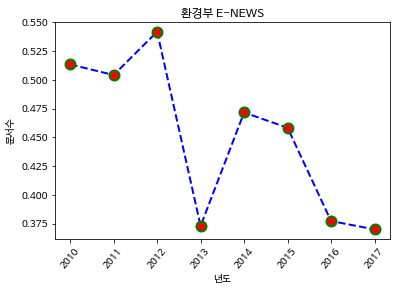

In [39]:
ma.doc_trend_analysis(title="환경부 E-NEWS",norm=True,ylab="문서수",prefix="c_")

In [135]:
ma.training_keyword_w2v('twitter')